In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.interpolate import interp1d
from scipy.optimize import root
import importlib
import classy
from scipy.special import sici
from classy import Class


In [2]:
h = 0.67810
_H0_ = 3.336e-04 * h
_ev_to_HO_ = 1.56e29 / _H0_
common_settings = {
'omega_b':0.0223828,
'h':h,
'z_reio':7.6711,
'YHe':0.25,
'perturbations_verbose':1,
'background_verbose':3,
'output':'mTk, vTk, mPk',
'P_k_max_1/Mpc':10,
'z_max_pk':1000,
'format':'class',
}
print(1.e-26* _ev_to_HO_)

6896120.03068243


In [3]:
# ChatGPT says that 1 eV = 4.827e19 invMpc
chiCDM = Class()
chiCDM.set(common_settings)

m_ev = 1.e-26
chiCDM.set({
    'omega_cdm': 0.12,
    'scf_potential': 'axion',
    'n_axion': 1,
    'f_axion': 0.4,  # in units of mpl
    'omega_scf' : 0.02,
    'm_axion': m_ev * _ev_to_HO_,  # in units of H0
    'tol_shooting_deltax': 1e-4,
    'tol_shooting_deltaF': 1e-4,
    'scf_parameters': '0.05,0.0',  # note: if Omega_scf is set, the parameter entry corresponding to scf_tuning_index is ignored and used for shooting.
    'scf_tuning_index': 0,  # in this example, we shoot over theta_ini in order to adjust Omega_scf.
    'scf_evolve_as_fluid': 'yes',  # if set to yes, will switch for fluid when threshold_scf_fluid_m_over_H is met
    'scf_evolve_like_axionCAMB': 'yes',  # fluid all the time in perts, the option no is currently bugging, to be debugged
    'threshold_scf_fluid_m_over_H': 3,  # threshold_scf_fluid_m_over_H controls when to switch to fluid
    'do_shooting': 'yes',  # controls shooting in general; e.g. theta_s
    'do_shooting_scf': 'yes',  # necessary when log10_axion_ac & log10_fraction_axion_ac are chosen
    'scf_has_perturbations': 'yes',  # for pedagogical purposes only
    'use_big_theta_scf': 'no',  # in perts with the fluid it is often more stable to follow the heat flux rather "Big Theta=(1+w)*Theta" than the velocity divergence "Theta"
    'use_delta_scf_over_1plusw': 'no',
    'attractor_ic_scf': 'no',  # some specific IC for tracker potentials
    'evolver': 0
})

chiCDM.compute()
#get the growth factor of a LCDM equivalent
pureCDM = Class()
pureCDM.set(common_settings)
pureCDM.set({
    'N_ur': 3.046,
    'omega_cdm':0.12,

})
pureCDM.compute()


CosmoSevereError: 

Error in Class: Class did not read input parameter(s): omega_scf


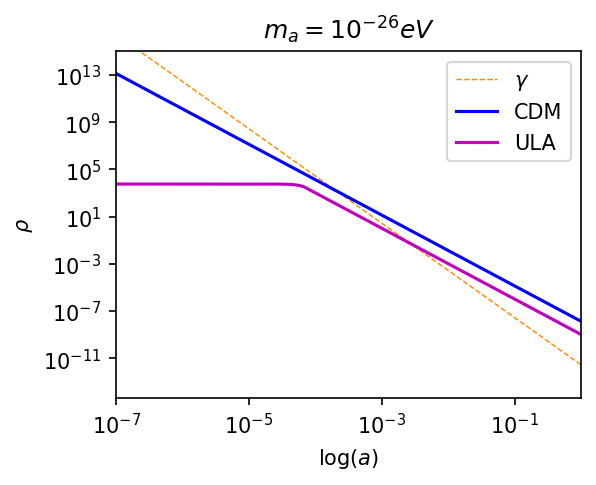

In [31]:
plt.figure(figsize=(4,3), dpi=150)

chibck = chiCDM.get_background() # load background table
a = 1/(chibck['z']+1) # read redshift
rho_cdm=chibck['(.)rho_cdm']
rho_ax=chibck['(.)rho_scf']
rho_g=chibck['(.)rho_g']
rho_crit=chibck['(.)rho_crit']

plt.xlabel(r'$a $')
plt.loglog(a,rho_g,'darkorange', linestyle='--',linewidth=0.7, label=r'$\gamma$')
plt.loglog(a,rho_cdm, 'b', label=r'CDM')
plt.loglog(a,rho_ax, 'm', label=r'ULA')


plt.xlim([1.e-7,1])
plt.ylim([None,1.e15])
plt.legend(loc='best')
plt.xscale('log')
plt.xlabel(r'$\log(a)$')
plt.ylabel(r'$\rho$')
plt.title(r'$m_a = 10^{-26}eV$')
plt.show()


---
now look at transfer functions

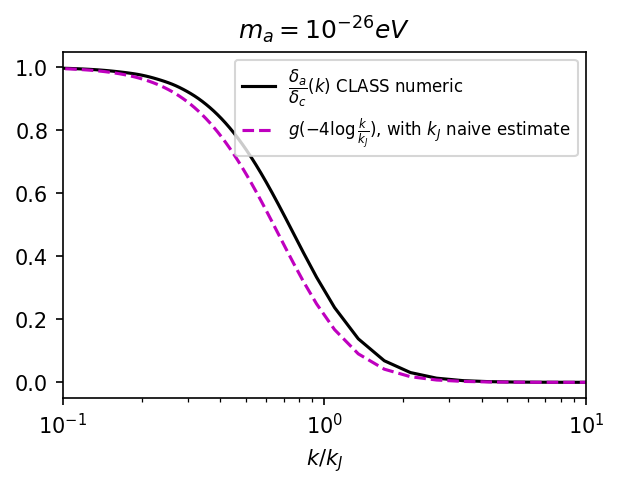

In [34]:
zeval = 0.5
chi_tk_k = chiCDM.get_transfer(z=zeval)

kEval=chi_tk_k['k (h/Mpc)']
d_ax_k=-chi_tk_k['d_scf']
d_cdm_k=-chi_tk_k['d_cdm']

T_ratio_k =d_ax_k/ d_cdm_k

def g_an(t):
    return  1 + 6 * np.exp(-t) * np.cos(np.sqrt(6) * np.exp(-t / 2)) * sici(np.sqrt(6) * np.exp(-t / 2))[1] - 3 * np.exp(-t) * np.pi * np.sin(np.sqrt(6) * np.exp(-t / 2)) + 6 * np.exp(-t) * np.sin(np.sqrt(6) * np.exp(-t / 2)) * sici(np.sqrt(6) * np.exp(-t / 2))[0]

# H0p5 = Ha_chi_int(0.666)/0.666
# kJ0p5 = np.sqrt(H0p5 * m_ax)/0.67810
kJest = np.sqrt(3.336e-04 * h * m_ev * 1.56e29)/h * (0.6666)**0.25

plt.figure(figsize=(4.5,3), dpi=150)
plt.plot(kEval, T_ratio_k,'k',label=r'$\dfrac{\delta_a}{\delta_c}(k)$ CLASS numeric')
plt.plot(kEval, g_an(-4*np.log(kEval/(kJest))),'m--',label=r'$g(-4\log \frac{k}{k_J})$, with $k_J$ naive estimate')
# plt.plot(kEval, g_an(-2*np.log(kEval/(kJ0p5))),'g--',linewidth=0.7, label=r'$g(-2\log \frac{k}{k_J})$')

# plt.axvline(kJ0p5, color='g', linestyle=':', linewidth=0.5,label=r'$k_J$ estim')


plt.xscale('log')
plt.xlabel(r'$k/k_J$')
plt.legend(loc='upper right', fontsize=8)
plt.xlim([1.e-1,1.e1])
plt.title(r'$m_a = 10^{-26}eV$')
plt.show()

----
now look at the power spectrum

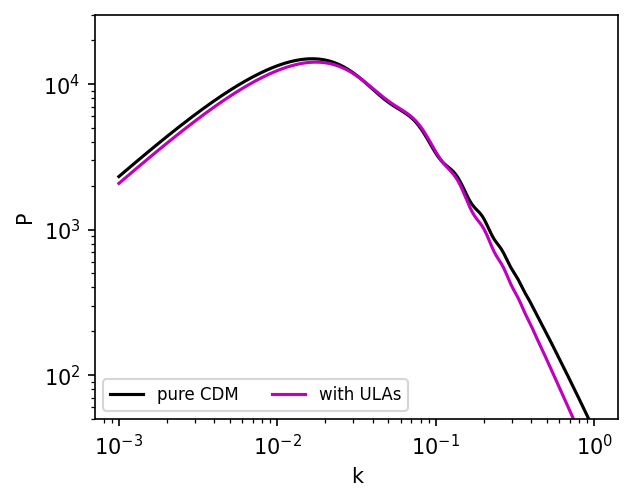

2.3010299956639813 -0.3010299956639812


In [27]:
kk = np.logspace(-3.,0.,200); h = chiCDM.h(); Pk_list=[]
for k in kk:
    Pk_list.append([chiCDM.pk_lin(k*h,0.5)*h**3,pureCDM.pk_lin(k*h,0.5)*h**3]) # function .pk(k,z)
Pk_list=np.array(Pk_list).T

plt.figure(figsize=(4.5,3.5), dpi=150)
plt.plot(kk, Pk_list[1], 'k', label=f'pure CDM')
plt.plot(kk, Pk_list[0],'m', label=f'with ULAs')

plt.ylim([50,3e4])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P')
plt.legend(loc='lower left', fontsize=8, ncol=2)

plt.show()
print(np.log10(200),np.log10(0.5))